<div align="center" style="color: purple">

# **Mona Lisa**

</div>

# TODO

- Zająć się na razie rysowaniem tylko kółek. Reszta zostanie dodana
- Pierwsze podejście zroobić HC
- Przejrzeć jeszcze kod, który został narazie napisany
- Napisać jaki problem rozwiązujemy po angielsku

Na razie ciekawoski, zauwamy ze w naszej funkcji celu. Im funkcja blizej 50 procent
poprawności tym mniej się zgadza z rzeczywistym obrazem dla człowieka.
Łatwo to zrozumieć, bo funkcja celu wyznacza wartośc na podstawie róznicy 

Mamy dwa podejścia jedno jest z hill climbingiem i będziemy dodawać figury, do momentu, az osiągniemy tyle kółek ile chcmey

Drugie podejście ze korzystamy z wszytskich kółek i potem jakoś je modyfikujey jeszcze nie wiem jak

## Problem oraz opis

Gen wygląda następująco (środek figury, distance, kąt i kolor)

### KONFIGURAJCA

In [43]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

NUM_CIRCLES = 10
MONA_LISA_FILENAME = "mona_lisa.jpg"
OBJECTIVE_IMAGE = np.array(Image.open(MONA_LISA_FILENAME).convert("RGBA"))

# print(OBJECTIVE_IMAGE)
print(OBJECTIVE_IMAGE.shape)
HEIGHT, WIDTH, NUM_CHANELLS =  OBJECTIVE_IMAGE.shape

(756, 500, 4)


## Function Add Polygon

In [44]:
from PIL import Image, ImageDraw

def add_polygon(base_img, x, y, d, angle, color_rgba, p):
    assert p > 2, "Polygon have to have more than 2 angles"

    layer = Image.new("RGBA", base_img.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(layer)

    points = []
    for i in range(p):
        ang = np.pi * i / 2 + angle
        px = x + d * np.cos(ang)
        py = y + d * np.sin(ang)
        points.append((px, py))

    draw.polygon(points, fill=color_rgba)

    return Image.alpha_composite(base_img, layer)
    

## Function Add Circle

In [45]:
from PIL import Image, ImageDraw

def add_circle(base_img, x, y, r, color_rgba):
    layer = Image.new("RGBA", base_img.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(layer)

    draw.ellipse(
        (x - r, y - r, x + r, y + r),
        fill=color_rgba
    )

    return Image.alpha_composite(base_img, layer)


## Function Add Square

In [46]:
from PIL import Image, ImageDraw

def add_square(base_img, x, y, d, angle, color_rgba):
    layer = Image.new("RGBA", base_img.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(layer)

    points = []
    for i in range(4):
        ang = np.pi * i / 2 + angle
        px = x + d * np.cos(ang)
        py = y + d * np.sin(ang)
        points.append((px, py))

    draw.polygon(points, fill=color_rgba)

    return Image.alpha_composite(base_img, layer)


## Function Add Triangle

In [47]:
from PIL import Image, ImageDraw

def add_triangle(base_img, x, y, side, angle, color_rgba):
    """
    Rysuje trójkąt równoboczny o boku 'side'
    obrócony o 'angle' wokół środka (x,y)
    """
    layer = Image.new("RGBA", base_img.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(layer)

    # promień okręgu opisanego
    R = side / np.sqrt(3)

    points = []
    for i in range(3):
        ang = 2 * np.pi * i / 3 + angle
        px = x + R * np.cos(ang)
        py = y + R * np.sin(ang)
        points.append((px, py))

    draw.polygon(points, fill=color_rgba)

    return Image.alpha_composite(base_img, layer)


## Generate Individual

In [48]:
GENE_SIZE = 7

def create_random_individual(
    num_circles: int = NUM_CIRCLES,
    rng: np.random.Generator | None = None,
) -> np.ndarray:
    """
    Tworzy losowego osobnika.
    Zwraca macierz shape = (num_circles, 7), wartości w [0, 1].
    """
    if rng is None:
        rng = np.random.default_rng()

    # każdy gen w [0, 1]
    individual = rng.random(size=(num_circles, GENE_SIZE), dtype=np.float32)
    return individual

## Generate Population

## Render Individual

In [49]:
GENE_SIZE = 7

def render_individual(
    individual: np.ndarray,
    width: int,
    height: int,
    shape: str = 'circle',
    max_radius_ratio: float = 0.25,
    background_color: tuple[int, int, int, int] = (255, 255, 255, 255),
) -> Image.Image:

    # assert individual.ndim == 2 and individual.shape[1] == GENE_SIZE, \
    #     "Individual must have shape (num_circles, 7)"

    # assert shape in ("circle", "square", "triangle"), \
    #     "shape must be one of: circle, square, triangle"

    img = Image.new("RGBA", (width, height), background_color)

    max_radius = int(min(width, height) * max_radius_ratio)

    for gene in individual:
        x_norm, y_norm, r_norm, R_norm, G_norm, B_norm, A_norm = gene

        x = int(x_norm * (width - 1))
        y = int(y_norm * (height - 1))

        r = int(5 + r_norm * (max_radius - 1))

        R = int(R_norm * 255)
        G = int(G_norm * 255)
        B = int(B_norm * 255)
        A = int(A_norm * 255)

        color = (R, G, B, A)

        angle = r_norm * 2 * np.pi  # obrót dla kwadratu/ trójkąta

        if shape == "circle":
            img = add_circle(img, x, y, r, color)

        elif shape == "square":
            # d = połowa przekątnej (spójne skalowanie z promieniem koła)
            d = r
            img = add_square(img, x, y, d, angle, color)

        elif shape == "triangle":
            # bok równobocznego tak, aby objętość figury miała podobną skalę
            side = r * 2
            img = add_triangle(img, x, y, side, angle, color)

    return img


## Objective Function

In [50]:
import numpy as np
from PIL import Image
from functools import lru_cache


@lru_cache(maxsize=8)
def _load_objective_image(filename: str) -> np.ndarray:
    """
    Wczytuje obraz wzorcowy w trybie RGBA i cache'uje wynik,
    aby uniknąć wielokrotnego odczytu z dysku.
    """
    return np.array(Image.open(filename).convert("RGBA"))


def objective_function(
    image: np.ndarray,
    filename: str = "mona_lisa.jpg",
    error_type: str = "mse",
) -> float:
    """
    Funkcja celu porównująca obraz generowany z obrazem wzorcowym.

    Parametry:
        image      — obraz kandydata (RGBA, np.ndarray)
        filename   — ścieżka do obrazu wzorcowego
        error_type — 'mse' (Mean Squared Error) lub 'mae' (Mean Absolute Error)

    Zwraca:
        fitness (float) — ujemna wartość błędu (maksymalizacja podobieństwa)
    """

    ref = _load_objective_image(filename)

    assert ref.shape == image.shape, \
        "Image must be the same format as the objective image"

    # Rzutowanie do typu całkowitego z zapasem,
    # aby uniknąć przepełnień przy różnicach i potęgowaniu
    img_i32 = image.astype(np.int32)
    ref_i32 = ref.astype(np.int32)

    diff = img_i32 - ref_i32

    if error_type == "mse":
        # Mean Squared Error
        error = np.mean(diff * diff)
    elif error_type == "mae":
        # Mean Absolute Error
        error = np.mean(np.abs(diff))
    else:
        raise ValueError(f"Unsupported error_type: {error_type}")

    # Maksymalizujemy dopasowanie — minimalizujemy błąd
    return -float(error)


## Similarity Score

In [51]:
def similarity_score(
    image: np.ndarray,
    filename: str = "mona_lisa.jpg",
    error_type: str = "mse",
) -> float:
    """
    Zwraca procentowe podobieństwo obrazu do wzorca (0–100%).

    100%  -> obrazy identyczne
    0%    -> maksymalna różnica pikselowa
    """

    ref = _load_objective_image(filename)

    assert ref.shape == image.shape, \
        "Image must be the same format as the objective image"

    img_i32 = image.astype(np.int32)
    ref_i32 = ref.astype(np.int32)

    diff = img_i32 - ref_i32

    if error_type == "mae":
        # Mean Absolute Error w jednostkach koloru (0..255)
        err = np.mean(np.abs(diff))

    elif error_type == "mse":
        # RMSE daje błąd w tej samej skali co piksele
        mse = np.mean(diff * diff)
        err = np.sqrt(mse)

    else:
        raise ValueError(f"Unsupported error_type: {error_type}")

    # normalizacja do [0,1]
    # 0 -> brak błędu, 1 -> maksymalny błąd 255
    err_norm = np.clip(err / 255.0, 0.0, 1.0)

    # zamiana na podobieństwo
    similarity = 1.0 - err_norm

    return float(similarity * 100.0)

## Evaluate Individual

In [52]:
# Przykład użycia razem z Twoją objective_function
def evaluate_individual(individual: np.ndarray,
                        target_filename: str = "mona_lisa.jpg",
                        error_type: str = "mse") -> float:
    """
    Liczy fitness osobnika na podstawie objective_function.
    Zakładamy, że rozmiar obrazu jest taki sam jak docelowy.
    """
    # Wczytujemy obraz docelowy, żeby poznać wymiary
    target_img = Image.open(target_filename).convert("RGBA")
    width, height = target_img.size

    # render osobnika
    candidate_array = np.array(render_individual(individual, width, height), dtype=np.uint8)

    # objective_function, którą już masz zdefiniowaną
    return objective_function(candidate_array, filename=target_filename, error_type=error_type)


def evaluate(base, circle):
    x, y, r, R, G, B, A = circle

    base = add_circle(base, x, y, r, (R, G, B, A))

    return objective_function(np.array(base))
    

## Incremental Hill Climb

In [ ]:
import numpy as np

MAX_CIRCLES = 20

def generate_circle():
    return np.random.uniform(size=GENE_SIZE)


def hill_climb(
    circle,
    individual: np.ndarray,
    steps: int = 200,
    step_size: float = 0.05,
):
    
    base = render_individual(individual, WIDTH, HEIGHT)
    best = circle.copy()
    best_fitness = evaluate(base, circle)

    for _ in range(steps):

        gene_idx = np.random.randint(0, 7)

        # mała zmiana
        delta = np.random.normal(0, step_size)

        circle[gene_idx] = np.clip(
            circle[gene_idx] + delta,
            0.0, 1.0
        )

        fitness = evaluate(base, circle)

        # akceptujemy tylko poprawę
        if fitness > best_fitness:
            best = circle.copy()
            best_fitness = fitness

    return best, best_fitness


def incremental_hill_climb(
        max_circles: int = MAX_CIRCLES
    ):

    individual = []

    for i in range(max_circles):
        circle = generate_circle()

        circle = hill_climb(circle, individual)

        individual.append(circle)

    return individual

print(incremental_hill_climb(MAX_CIRCLES))

TypeError: 'numpy.float64' object cannot be interpreted as an integer

## Hill Climbing

Weźmy sobie rysowanie za pomocą kwadratów, albo

In [ ]:
print(np.random.uniform(size=10))

[0.61482634 0.30304328 0.74770164 0.05753338 0.04719917 0.96415769
 0.25299007 0.86807959 0.72521561 0.93849761]


<div align="center" style="color: purple">

# **Objective Function**

</div>

Pomysły L1 lub L2, dodanie wagi na kazdy parametr RGBA. Coś jeszcze w sumie

In [ ]:
import numpy as np
from PIL import Image
from functools import lru_cache


@lru_cache(maxsize=8)
def _load_objective_image(filename: str) -> np.ndarray:
    """
    Wczytuje obraz wzorcowy w trybie RGBA i cache'uje wynik,
    aby uniknąć wielokrotnego odczytu z dysku.
    """
    return np.array(Image.open(filename).convert("RGBA"))


def objective_function(
    image: np.ndarray,
    filename: str = "mona_lisa.jpg",
    error_type: str = "mse",
) -> float:
    """
    Funkcja celu porównująca obraz generowany z obrazem wzorcowym.

    Parametry:
        image      — obraz kandydata (RGBA, np.ndarray)
        filename   — ścieżka do obrazu wzorcowego
        error_type — 'mse' (Mean Squared Error) lub 'mae' (Mean Absolute Error)

    Zwraca:
        fitness (float) — ujemna wartość błędu (maksymalizacja podobieństwa)
    """

    ref = _load_objective_image(filename)

    assert ref.shape == image.shape, \
        "Image must be the same format as the objective image"

    # Rzutowanie do typu całkowitego z zapasem,
    # aby uniknąć przepełnień przy różnicach i potęgowaniu
    img_i32 = image.astype(np.int32)
    ref_i32 = ref.astype(np.int32)

    diff = img_i32 - ref_i32

    if error_type == "mse":
        # Mean Squared Error
        error = np.mean(diff * diff)
    elif error_type == "mae":
        # Mean Absolute Error
        error = np.mean(np.abs(diff))
    else:
        raise ValueError(f"Unsupported error_type: {error_type}")

    # Maksymalizujemy dopasowanie — minimalizujemy błąd
    return -float(error)


# Przykładowy indvidual oraz jego ewaluacja

In [ ]:
# import numpy as np
# from PIL import Image, ImageDraw

# NUM_CIRCLES = 100
# GENE_SIZE = 7  # x, y, r, R, G, B, A


# def create_random_individual(
#     num_circles: int = NUM_CIRCLES,
#     rng: np.random.Generator | None = None,
# ) -> np.ndarray:
#     """
#     Tworzy losowego osobnika.
#     Zwraca macierz shape = (num_circles, 7), wartości w [0, 1].
#     """
#     if rng is None:
#         rng = np.random.default_rng()

#     # każdy gen w [0, 1]
#     individual = rng.random(size=(num_circles, GENE_SIZE), dtype=np.float32)
#     return individual

# indv = create_random_individual()


# def add_circle(base_img, x, y, r, color_rgba):
#     """Rysuje pojedyncze koło na osobnej warstwie i blenduje je z bazą."""
#     layer = Image.new("RGBA", (width, height), (0, 0, 0, 0))
#     draw = ImageDraw.Draw(layer)

#     draw.ellipse(
#         (x - r, y - r, x + r, y + r),
#         fill=color_rgba
#     )

#     return Image.alpha_composite(base_img, layer)

# def add_square(base_img, x, y, d, angle, color_rgb):

#     layer = layer = Image.new("RGBA", (width, height), (0, 0, 0, 0))
#     draw = ImageDraw.Draw(layer)

#     def square_points(x, y, d, angle):
#         res = []
#         # 
#         for i in range(4):
#             ang = np.pi * i / 2 + angle
#             new_x = x + d * np.cos(ang)
#             new_y = y + d * np.sin(ang)
#             res.append(new_x)
#             res.append(new_y)

#         return res
        

#     draw.polygon(
#         square_points(x, y, d, angle), 
#         fill=color_rgb
#     )

#     return Image.alpha_composite(base_img, layer)
    

# def render_individual(
#     individual: np.ndarray,
#     width: int,
#     height: int,
#     type: str = 'circle',
#     max_radius_ratio: float = 0.25,
#     background_color: tuple[int, int, int, int] = (255, 255, 255, 255),
# ) -> np.ndarray:
#     """
#     Renderuje obraz z kół opisanych przez osobnika.

#     Parametry:
#         individual       - macierz (num_circles, 7) z wartościami w [0, 1]
#         width, height    - rozmiar obrazu w pikselach
#         max_radius_ratio - maksymalny promień jako część krótszego boku obrazu
#         background_color - kolor tła (RGBA)

#     Zwraca:
#         obraz jako np.ndarray (height, width, 4), dtype=uint8, RGBA
#     """
#     assert individual.ndim == 2 and individual.shape[1] == GENE_SIZE, \
#         "Individual must have shape (num_circles, 7)"
    
#     assert type == ('circle' | 'square' | 'triangle'), "Render type must be one of (circle, square, triangle)"


    
#     img = Image.new("RGBA", (width, height), background_color)

#     max_radius = int(min(width, height) * max_radius_ratio)

#     for circle in individual:
#         x_norm, y_norm, r_norm, R_norm, G_norm, B_norm, A_norm = circle

#         # Pozycja środka
#         x = int(x_norm * (width - 1))
#         y = int(y_norm * (height - 1))

#         # Promień, minimum 1 px, żeby było cokolwiek widać
#         r = int(10 + r_norm * (max_radius - 1)) # Minimalny promień musi być
#         # if r <= 0:
#         #     continue

#         # Kolor RGBA
#         R = int(R_norm * 255)
#         G = int(G_norm * 255)
#         B = int(B_norm * 255)
#         A = int(A_norm * 255)

#         # Opcjonalne przycięcie do granic obrazu
#         # if right < 0 or bottom < 0 or left >= width or top >= height:
#         #     # koło całkowicie poza obrazem
#         #     continue

#         img = add_circle(img, x, y, r, (R, G, B, A))

#     return img # np.array(img, dtype=np.uint8),

# img = render_individual(indv, width=WIDTH, height=HEIGHT)

# dpi = 1
# fig = plt.figure(figsize=(width/dpi, height/dpi), dpi=dpi)
# ax = fig.add_axes([0, 0, 1, 1])

# ax.imshow(img)

# ax.axis('off')
# ax.set_frame_on(False)

# plt.show()

# # Przykład użycia razem z Twoją objective_function
# def evaluate_individual(individual: np.ndarray,
#                         target_filename: str = "mona_lisa.jpg",
#                         error_type: str = "mse") -> float:
#     """
#     Liczy fitness osobnika na podstawie objective_function.
#     Zakładamy, że rozmiar obrazu jest taki sam jak docelowy.
#     """
#     # Wczytujemy obraz docelowy, żeby poznać wymiary
#     target_img = Image.open(target_filename).convert("RGBA")
#     width, height = target_img.size

#     # render osobnika
#     candidate_array = np.array(render_individual(individual, width, height), dtype=np.uint8)

#     # objective_function, którą już masz zdefiniowaną
#     return objective_function(candidate_array, filename=target_filename, error_type=error_type)

# print(evaluate_individual(indv))


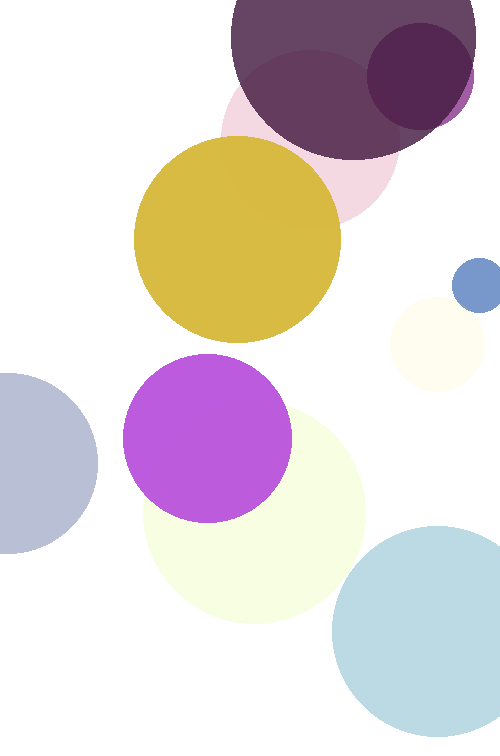

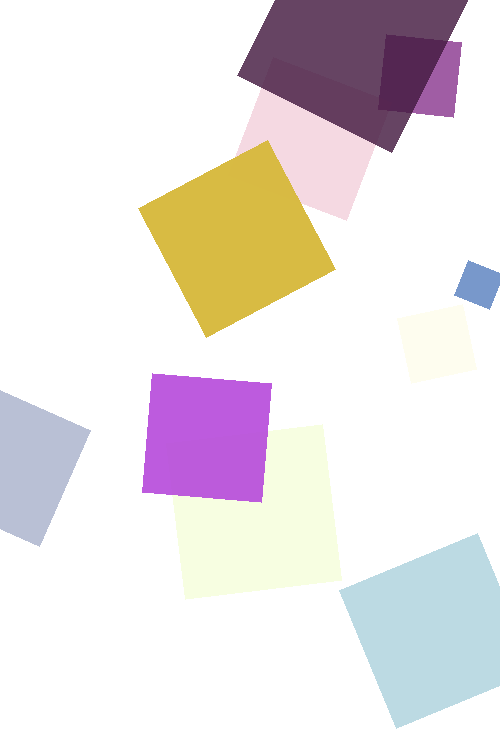

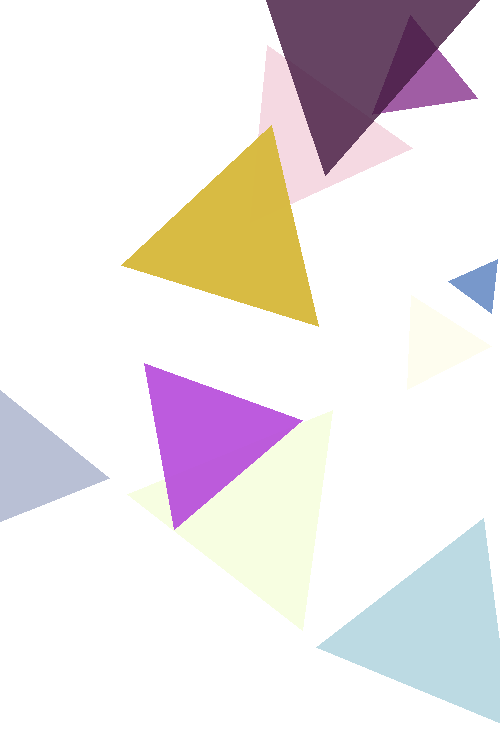

In [ ]:
import matplotlib.pyplot as plt

indv = create_random_individual()

img = render_individual(indv, WIDTH, HEIGHT, shape="circle")

dpi = 1
fig = plt.figure(figsize=(WIDTH/dpi, HEIGHT/dpi), dpi=dpi)
ax = fig.add_axes([0, 0, 1, 1])

ax.imshow(img)

ax.axis('off')
ax.set_frame_on(False)

plt.show()

img = render_individual(indv, WIDTH, HEIGHT, shape="square")

dpi = 1
fig = plt.figure(figsize=(WIDTH/dpi, HEIGHT/dpi), dpi=dpi)
ax = fig.add_axes([0, 0, 1, 1])

ax.imshow(img)

ax.axis('off')
ax.set_frame_on(False)

plt.show()

img = render_individual(indv, WIDTH, HEIGHT, shape="triangle")

dpi = 1
fig = plt.figure(figsize=(WIDTH/dpi, HEIGHT/dpi), dpi=dpi)
ax = fig.add_axes([0, 0, 1, 1])

ax.imshow(img)

ax.axis('off')
ax.set_frame_on(False)

plt.show()


